# Plot different trajectories

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

save_path = Path('figures')
save_path.mkdir(exist_ok=True, parents=True)

from simulators.radar import RadarCustomTwoTargets

sidelen = 300
lambd = .0015
PD = 1.
PG = .999
trajectories = {}
traj_types = ['angle', 'curve', 'line', 'trapezoid']

for traj_type in traj_types:
    r = RadarCustomTwoTargets(traj_type, common_offset=100, mirror_offset=1, R=1.8, lambd=lambd, debug=True)
    trajectories[traj_type] = np.array([i for i in r.get_measurements(clutter=False)])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Read trajectory from data/traj_angle.npy of 203 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_curve.npy of 163 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_line.npy of 202 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.


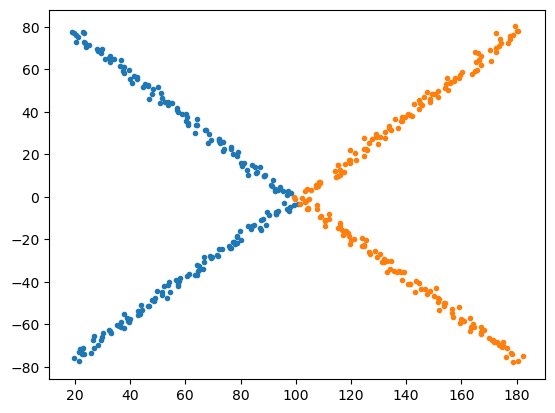

In [2]:
plt.plot(trajectories['angle'][:, :, 0], trajectories['angle'][:, :, 1], '.')

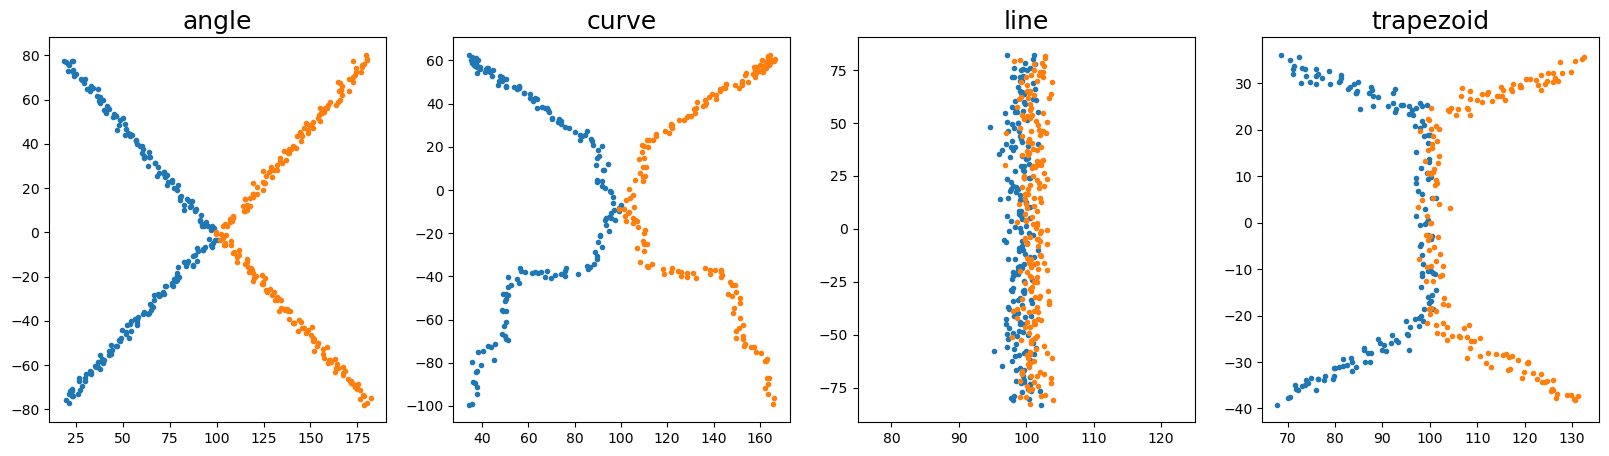

In [3]:
# plot trajectories
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, traj_type in enumerate(traj_types):
    if traj_type == 'line':
        ax[i].set_xlim(75, 125)
    ax[i].plot(trajectories[traj_type][:, :, 0], trajectories[traj_type][:, :, 1], '.')
    ax[i].set_title(traj_type, fontsize=18)
plt.savefig(save_path / '05_01_all_traj.svg', format='svg', dpi=300)

## Mirror offset

In [4]:
mirror_offsets = [1, 10, 20]
traj_type = 'trapezoid'
trajectories_mo = {}

for mirror_offset in mirror_offsets:
    r = RadarCustomTwoTargets(traj_type, common_offset=100, mirror_offset=mirror_offset, R=1.8, lambd=lambd, debug=True)
    trajectories_mo[mirror_offset] = np.array([i for i in r.get_measurements(clutter=False)])

Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 10 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 20 to x.


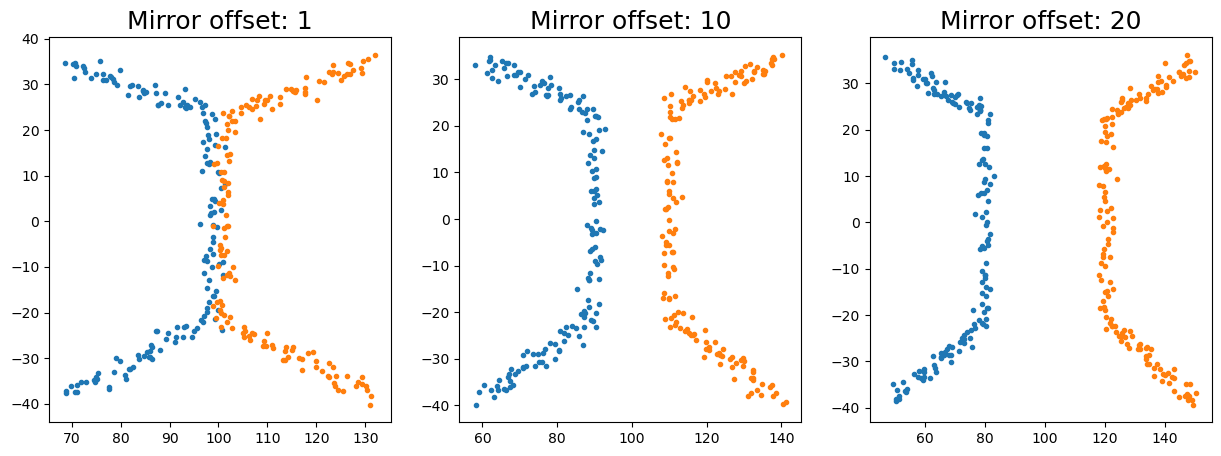

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, mirror_offset in enumerate(mirror_offsets):
    ax[i].plot(trajectories_mo[mirror_offset][:, :, 0], trajectories_mo[mirror_offset][:, :, 1], '.')
    ax[i].set_title(f'Mirror offset: {mirror_offset}', fontsize=18)
# plt.show()
plt.savefig(save_path / '05_02_mirror_offset.svg', format='svg', dpi=300)

## Different clutter rates

In [6]:
clutter_rates = [0.0001, 0.001, 0.003]
traj_type = 'trapezoid'
trajectories_cr = {}

for clutter_rate in clutter_rates:
    r = RadarCustomTwoTargets(traj_type, common_offset=100, mirror_offset=1, R=1.8, lambd=clutter_rate, debug=True)
    trajectories_cr[clutter_rate] = [i for i in r.get_measurements(clutter=True)]

Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.


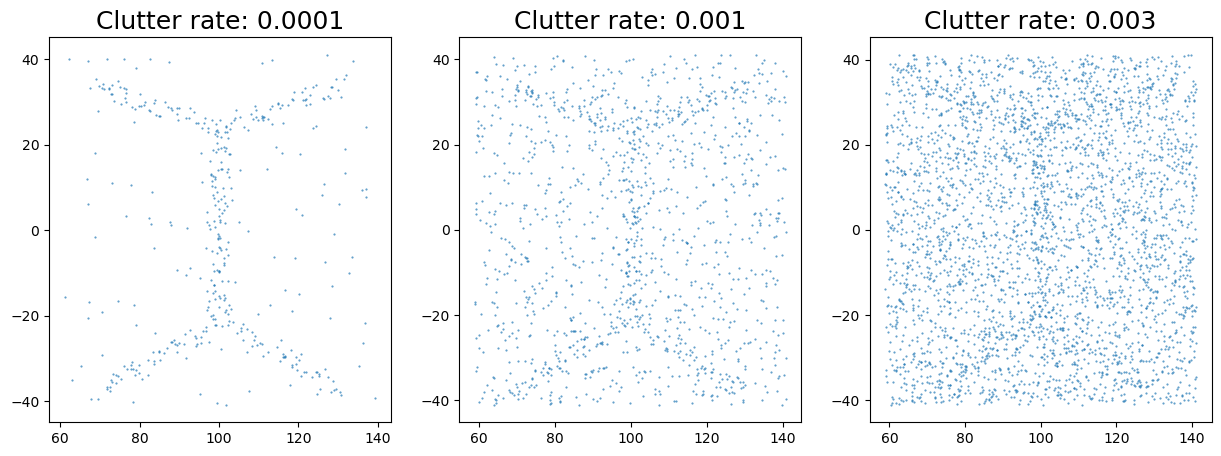

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, clutter_rate in enumerate(clutter_rates):
    for c_data in trajectories_cr[clutter_rate]:
        axs[i].plot(c_data[:, 0], c_data[:, 1], '.', color='tab:blue', alpha=0.8, markersize=1)
    axs[i].set_title(f'Clutter rate: {clutter_rate}', fontsize=18)
# plt.show()
plt.savefig(save_path / '05_03_clutter_rate.svg', format='svg', dpi=300)

## Different R

In [8]:
Rs = [1, 5, 10]
traj_type = 'trapezoid'
trajectories_R = {}

for R in Rs:
    r = RadarCustomTwoTargets(traj_type, common_offset=100, mirror_offset=1, R=R, lambd=lambd, debug=True)
    trajectories_R[R] = np.array([i for i in r.get_measurements(clutter=False)])

Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_trapezoid.npy of 154 points. Applied mirror offset of 1 to x.


In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, R in enumerate(Rs):
    axs[i].plot(trajectories_R[R][:, :, 0], trajectories_R[R][:, :, 1], '.')
    axs[i].set_title(f'R: {R}', fontsize=18)

plt.savefig(save_path / '05_04_R.svg', format='svg', dpi=300)

## One run with error for all algorithms

In [10]:
from models.JPDA import JPDA
from models.JPDA_star import JPDA_star
from models.JPDA_mine import JPDA_mine
from models.utils import calculate_gospa

In [12]:
import json
from tqdm import tqdm


def run_three_alg(*args, **kwargs):
    """kwargs must must contain
    out_path - path to save results
    R - measurement noise covariance
    P_D - probability of detection
    P_G - probability of gating
    traj_type - type of trajectory
    mirror_offset - mirror offset
    lambd - clutter rate

    squeeze_PG - squeeze PG
    squeeze_seq_limit - squeeze sequence limit
    cooldown - cooldown
    """
    np.random.seed(1998)
    models = ['JPDA', 'JPDA*', 'Ours']
    model_classes = {
        'JPDA': JPDA,
        'JPDA*': JPDA_star,
        'Ours': JPDA_mine
    }
    markers = {
        'JPDA': 'o',
        'JPDA*': '*',
        'Ours': 's'
    }
    colors = {
        'JPDA': 'tab:blue',
        'JPDA*': 'tab:orange',
        'Ours': 'tab:green'
    }
    targets = []
    estimates = {model: [] for model in models}
    GOSPAS = {model: [] for model in models}
    RMSES = {model: [] for model in models}
    misdetections_cumulative = {model: [] for model in models}

    F = np.array([[1, 1, 0, 0],  # state transition matrix
                  [0, 1, 0, 0],
                  [0, 0, 1, 1],
                  [0, 0, 0, 1]])

    H = np.array([[1., 0, 0, 0],  # measurement matrix
                  [0., 0, 1, 0]])
    Q = np.diag([.1, .1, .01, .01])  # process noise covariance
    R = kwargs['R'] * np.eye(2)  # measurement noise covariance

    PD = kwargs['P_D']  # probability of detection
    PG = kwargs['P_G']  # probability of gating

    frames_path = kwargs['out_path'] / "frames"
    frames_path.mkdir(parents=True, exist_ok=True)

    r = RadarCustomTwoTargets(
        kwargs['traj_type'],
        common_offset=100,
        mirror_offset=kwargs['mirror_offset'],
        R=kwargs['R'],
        lambd=kwargs['lambd'],
        debug=False)

    radar_stream = r.get_measurements(clutter=True)
    _ = next(radar_stream)
    radar_x0 = r.x[0]

    filters = [
        JPDA(F, H, Q, R, PD=PD, PG=PG, lambd=kwargs['lambd'], x_0=radar_x0.T),
        JPDA_star(F, H, Q, R, PD=PD, PG=PG, lambd=kwargs['lambd'], x_0=radar_x0.T),
        JPDA_mine(F, H, Q, R, PD=PD, PG=PG, lambd=kwargs['lambd'], squeeze_PG=kwargs['squeeze_PG'],
                  squeeze_seq_limit=kwargs['squeeze_seq_limit'], cooldown=kwargs['cooldown'], x_0=radar_x0.T)
    ]

    for k in tqdm(range(r.get_trajectory_length() - 1)):
        # print(f"Running iteration {k}")
        fig, ax = plt.subplots(figsize=(10, 10))
        x_min, x_max, y_min, y_max = r.get_traj_bounding_box()
        ax.set_xlim((-r.area_side_len / 2 + r.common_offset, r.area_side_len / 2 + r.common_offset))
        ax.set_ylim((-r.area_side_len, r.area_side_len))

        z_all = next(radar_stream)  # get measurements
        plt.plot(z_all[:, 0], z_all[:, 1], '.', markersize=1.8, color='grey', label='$\mathbf{Z}_t$')  # plot all measurements

        targets.append(r.x[-1].copy())

        # Plot true but unknown x
        plt.plot(np.array(targets)[:, :, 0], np.array(targets)[:, :, 2], '*', markersize=2., color='black', label='$\mathbf{x}_t$')

        for filt in filters:
            filt.predict()

        for filter_name, filter_inst in zip(models, filters):
            c_rmse = np.sqrt(np.square(np.subtract(filter_inst.x, r.x[k].T)).mean())
            c_gospa = calculate_gospa(filter_inst.x, r.x[k].T, c=20, p=2)
            GOSPAS[filter_name].append(c_gospa)
            RMSES[filter_name].append(c_rmse)

        # Plot estimated x
        for filter_name, filter_inst in zip(models, filters):
            if estimates[filter_name] != []:
                plt.plot(np.array(estimates[filter_name])[:, 0], np.array(estimates[filter_name])[:, 2], '--', color=colors[filter_name], alpha=.7)
            plt.plot(filter_inst.z[0], filter_inst.z[1], markers[filter_name], color=colors[filter_name], markersize=10, alpha=.8, label=f'{filter_name} estimate')
            filter_inst.update(z_all)
            filter_inst.log(k)
            estimates[filter_name].append(filter_inst.x.copy())
            misdetections_cumulative[filter_name].append(filter_inst.misdetections)

        # Point to think about: Should we compute RMSE and GOSPA after update?

        # save figure
        plt.legend(fontsize=14)
        plt.savefig(frames_path / f"{k:05d}.svg", bbox_inches='tight', dpi=300)
        plt.close()

    return targets, estimates, GOSPAS, RMSES, misdetections_cumulative


def run_simulation_and_plot(scenario_parameters):
    # Run the simulation for all three algorithms
    targets, estimates, GOSPAS, RMSES, misdetections_cumulative = run_three_alg(**scenario_parameters)
    plot_misdetections = any([any(m) for m in misdetections_cumulative.values()])
    n_axes = 3 if plot_misdetections else 2
    height = 18 if plot_misdetections else 12
    # Create a figure and a 3x1 grid of subplots
    fig, axs = plt.subplots(n_axes, 1, figsize=(10, height))


    # Plot the RMSE, GOSPA, and misdetections data in separate subplots
    for model in estimates.keys():
        axs[0].plot(RMSES[model], label=model)
        axs[1].plot(GOSPAS[model], label=model)
        if plot_misdetections:
            axs[2].plot(misdetections_cumulative[model], label=model)

    # Set the titles and labels for the subplots
    axs[0].set_title('RMSE vs Timestamp', fontsize=24)
    axs[0].set_xlabel('Timestamp', fontsize=18)
    axs[0].set_ylabel('RMSE', fontsize=18)

    axs[1].set_title('GOSPA vs Timestamp', fontsize=24)
    axs[1].set_xlabel('Timestamp', fontsize=18)
    axs[1].set_ylabel('GOSPA', fontsize=18)

    if plot_misdetections:
        axs[2].set_title('Misdetections vs Timestamp', fontsize=24)
        axs[2].set_xlabel('Timestamp', fontsize=18)
        axs[2].set_ylabel('Misdetections', fontsize=18)

    # Add a legend to each subplot
    for ax in axs:
        ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(scenario_parameters['out_path'] / 'simulation_metrics.svg', format='svg', dpi=300)

    # dump the scenario_parameters
    with open(scenario_parameters['out_path'] / 'scenario_parameters.json', 'w') as f:
        scenario_parameters.pop('out_path')
        json.dump(scenario_parameters, f)


In [13]:
# Easy
scenario_parameters = {
    'out_path': Path('experiment_results/single_runs/easy'),
    'R': 1.,
    'P_D': 1.,
    'P_G': .999,
    'traj_type': 'trapezoid',
    'mirror_offset': 5,
    'lambd': .001,
    'squeeze_PG': .975,
    'squeeze_seq_limit': 3,
    'cooldown': 2
}
run_simulation_and_plot(scenario_parameters)

100%|██████████| 153/153 [00:26<00:00,  5.75it/s]


In [14]:
# Medium
scenario_parameters = {
    'out_path': Path('experiment_results/single_runs/medium'),
    'R': 1.5,
    'P_D': 1.,
    'P_G': .999,
    'traj_type': 'trapezoid',
    'mirror_offset': 3,
    'lambd': .0015,
    'squeeze_PG': .975,
    'squeeze_seq_limit': 3,
    'cooldown': 2
}
run_simulation_and_plot(scenario_parameters)

  0%|          | 0/153 [00:00<?, ?it/s]

100%|██████████| 153/153 [00:23<00:00,  6.57it/s]


In [15]:
# Hard
scenario_parameters = {
    'out_path': Path('experiment_results/single_runs/hard'),
    'R': 2.,
    'P_D': 1.,
    'P_G': .999,
    'traj_type': 'trapezoid',
    'mirror_offset': 3,
    'lambd': .003,
    'squeeze_PG': .975,
    'squeeze_seq_limit': 3,
    'cooldown': 2
}
run_simulation_and_plot(scenario_parameters)

  0%|          | 0/153 [00:00<?, ?it/s]

100%|██████████| 153/153 [00:24<00:00,  6.16it/s]


In [2]:
import matplotlib.pyplot as plt

## Fallen object plot


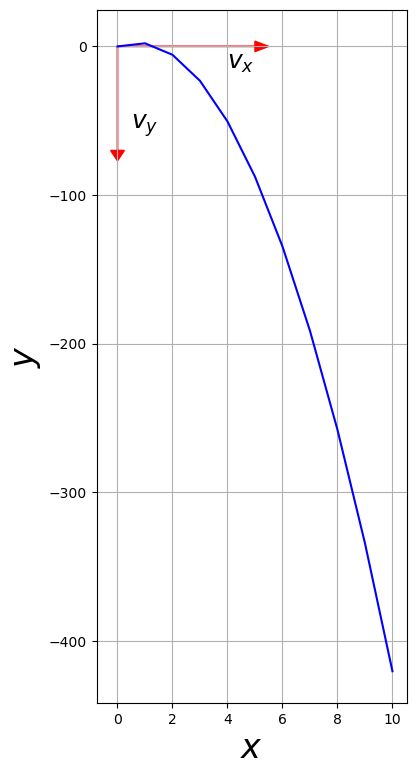

In [16]:
x, y = 5, 20
v = 7
g = 9.81
t = 2 * v / g

# plot fallen object trajectory parabola
fig, ax = plt.subplots(figsize=(4, 9))
t = 2 * v / g
t = round(t, 2)
x = [i for i in range(0, int(t * v) + 1)]
y = [v * i - 0.5 * g * i ** 2 for i in x]
plt.plot(x, y, color='blue')
plt.xlabel('$x$', fontsize=24)
plt.ylabel('$y$', fontsize=24)
# plt.title(f'Fallen object at time $t$', fontsize=24)
# add vectors of vx and v_y with captions
plt.arrow(0, 0, 5, 0, head_width=7, head_length=0.5, fc='red', ec='red')
plt.text(4, -15, '$v_x$', fontsize=18)
plt.arrow(0, 0, 0, -70, head_width=.5, head_length=7, fc='red', ec='red')
plt.text(0.5, -55, '$v_y$', fontsize=18)

plt.grid()
plt.savefig(save_path / '02_02_fallen_obj.svg', dpi=300, bbox_inches='tight', transparent=True)

## Clutter rate examples

In [22]:
# load some trajectories
x_log = np.load('experiment_results/param_grid/240427/baseline/curve/mirror_offset_5_lambd_0.001_R_0.5/x_log.npy')
# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_log[:, 0], x_log[:, 2], '--', markersize=2., color='black', label='$\mathbf{x}_t$')

In [23]:

clutter_rates = [0.001, 0.005, 0.01]
traj_type = 'curve'
trajectories_cr = {}
s_min, s_max = 50, 51

for clutter_rate in clutter_rates:
    r = RadarCustomTwoTargets(traj_type, common_offset=100, mirror_offset=1, R=3, lambd=clutter_rate, debug=True)
    trajectories_cr[clutter_rate] = [i for i in r.get_measurements(clutter=True)]
    trajectories_cr[clutter_rate] = trajectories_cr[clutter_rate][s_min:s_max]

Read trajectory from data/traj_curve.npy of 163 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_curve.npy of 163 points. Applied mirror offset of 1 to x.
Read trajectory from data/traj_curve.npy of 163 points. Applied mirror offset of 1 to x.


In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, clutter_rate in enumerate(clutter_rates):
    for c_data in trajectories_cr[clutter_rate]:
        axs[i].plot(c_data[:, 0], c_data[:, 1], '.', color='tab:blue', alpha=0.8, markersize=2)
    axs[i].plot(x_log[:s_max, 0], x_log[:s_max, 2], '--', markersize=2., color='black', label='$\mathbf{x}_t$')
    axs[i].set_title(f'$\Lambda = {clutter_rate}$', fontsize=18)
    axs[i].set_xlabel('$x$', fontsize=18)

axs[0].set_ylabel('$y$', fontsize=18)
plt.tight_layout()
# plt.show()
plt.savefig(save_path / '02_03_clutter_examples.svg', format='svg', dpi=300)

## Unknown data association diagram

In [25]:
x_prior = np.array([[3, 1, 2, .2], [1, 4, .7, 2]])
P = [np.eye(2) * 1.2, np.eye(2) * 1]
F = np.array([[1, 0, 1, 0],  # state transition matrix
              [0, 1, 0, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
x_predicted = x_prior @ F.T
measurements = np.array([
    [1.5, 7.2],
    [4.2, 5.1],
    [3.5, 4],
    [6.2, 0.5],
    [5.5, 2.5]
])

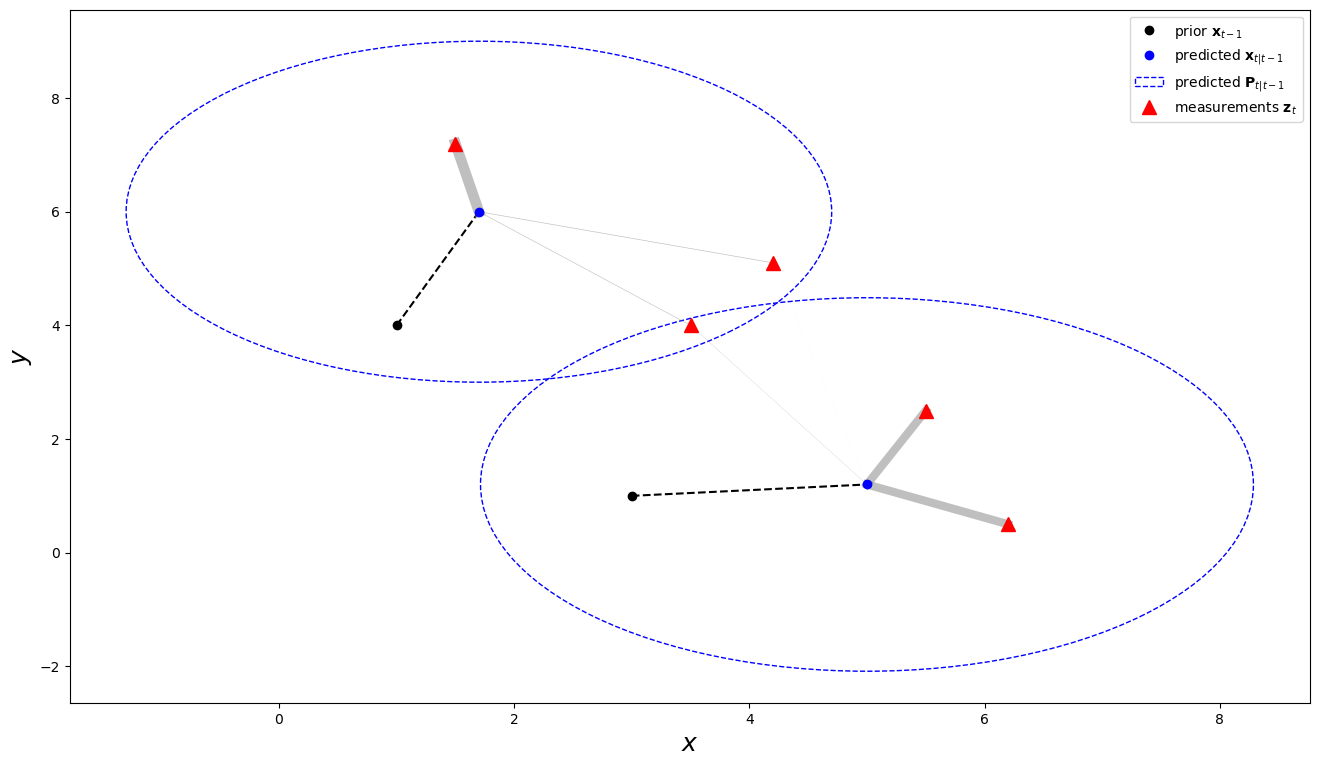

In [26]:
from models.utils import confidence_ellipse
import scipy.stats as st

fig, ax = plt.subplots(figsize=(16, 9))

# connect prior with predicted with dashed lines
for i in range(x_prior.shape[0]):
    ax.plot([x_prior[i, 0], x_predicted[i, 0]], [x_prior[i, 1], x_predicted[i, 1]], '--', color='black')

# plot all possible association with indecies
for i, x in enumerate(x_predicted):
    for j, z in enumerate(measurements):
        # make thicker for closer measurements
        distance = np.linalg.norm(x[:2] - z)
        likelihood = st.multivariate_normal.pdf(z, mean=x[:2], cov=P[i])
        ax.plot([x[0], z[0]], [x[1], z[1]], color='grey', alpha=0.5, linewidth=likelihood * 100)
        # association at the middle of the line
        # ax.text((x[0] + z[0]) / 2, (x[1] + z[1]) / 2, f'{i+1}{j+1}', fontsize=12)


# plot x_prior
ax.plot(x_prior[:, 0], x_prior[:, 1], 'o', color='black', label='prior $\mathbf{x}_{t-1}$')

# plot x_predicted
ax.plot(x_predicted[:, 0], x_predicted[:, 1], 'o', color='blue', label='predicted $\mathbf{x}_{t|t-1}$')
for i, P_i in enumerate(P):
    confidence_ellipse(x_predicted[i, :2], P_i, ax, rot=70 if i == 0 else 45, edgecolor='blue', linestyle='--',
                       label='predicted $\mathbf{P}_{t|t-1}$' if i ==0 else None)


# plot measurements
ax.plot(measurements[:, 0], measurements[:, 1], '^', color='red', label='measurements $\mathbf{z}_t$', markersize=10)

plt.legend()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
# plt.show()
plt.savefig(save_path / '02_04_unknown_data_association.svg', format='svg', dpi=300)

## PDA example

In [27]:
x_prior = np.array([[3, 1, 2, .2]])
P = [np.eye(2) * .8]
F = np.array([[1, 0, 1, 0],  # state transition matrix
              [0, 1, 0, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
x_predicted = x_prior @ F.T
measurements = np.array([
    [5, 2],
    [7, 1],
    [6,-1],
])


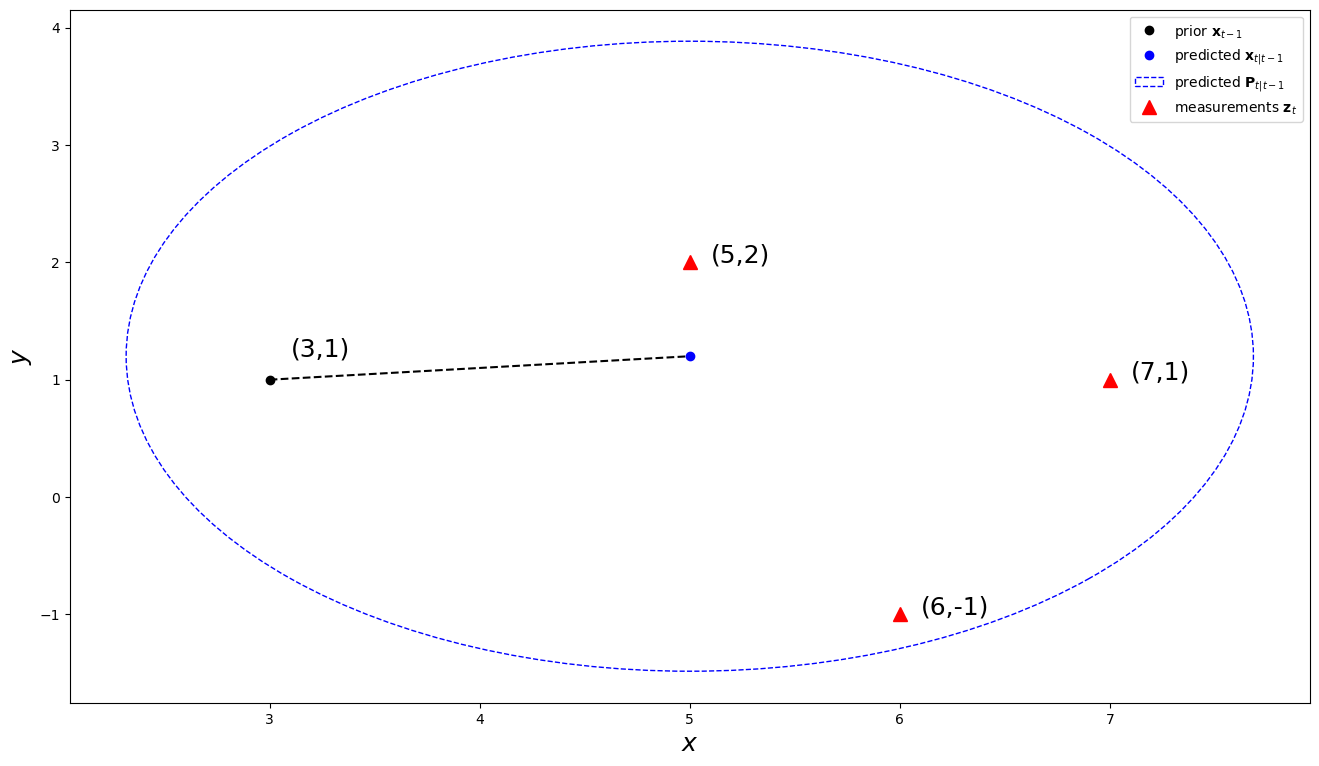

In [28]:
from models.utils import confidence_ellipse
import scipy.stats as st

fig, ax = plt.subplots(figsize=(16, 9))

# connect prior with predicted with dashed lines
for i in range(x_prior.shape[0]):
    ax.plot([x_prior[i, 0], x_predicted[i, 0]], [x_prior[i, 1], x_predicted[i, 1]], '--', color='black')

# plot all possible association with indecies
# for i, x in enumerate(x_predicted):
#     for j, z in enumerate(measurements):
#         # make thicker for closer measurements
#         distance = np.linalg.norm(x[:2] - z)
#         likelihood = st.multivariate_normal.pdf(z, mean=x[:2], cov=P[i])
#         ax.plot([x[0], z[0]], [x[1], z[1]], color='grey', alpha=0.5, linewidth=likelihood * 100)
#         # association at the middle of the line
#         # ax.text((x[0] + z[0]) / 2, (x[1] + z[1]) / 2, f'{i+1}{j+1}', fontsize=12)


# plot x_prior
ax.plot(x_prior[:, 0], x_prior[:, 1], 'o', color='black', label='prior $\mathbf{x}_{t-1}$')
# prior coordinates
for i, x in enumerate(x_prior):
    ax.text(x[0] + .1, x[1] + .2, f'({int(x[0])},{int(x[1])})', fontsize=18)

# plot x_predicted
ax.plot(x_predicted[:, 0], x_predicted[:, 1], 'o', color='blue', label='predicted $\mathbf{x}_{t|t-1}$')
for i, P_i in enumerate(P):
    confidence_ellipse(x_predicted[i, :2], P_i, ax, rot=70 if i == 0 else 45, edgecolor='blue', linestyle='--',
                       label='predicted $\mathbf{P}_{t|t-1}$' if i ==0 else None)

# plot measurements
ax.plot(measurements[:, 0], measurements[:, 1], '^', color='red', label='measurements $\mathbf{z}_t$', markersize=10)
# plot coordinates
for i, z in enumerate(measurements):
    ax.text(z[0] + .1, z[1], f'({z[0]},{z[1]})', fontsize=18)

plt.legend()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
# plt.show()
plt.savefig(save_path / '02_06_PDA_example_1.svg', format='svg', dpi=300)

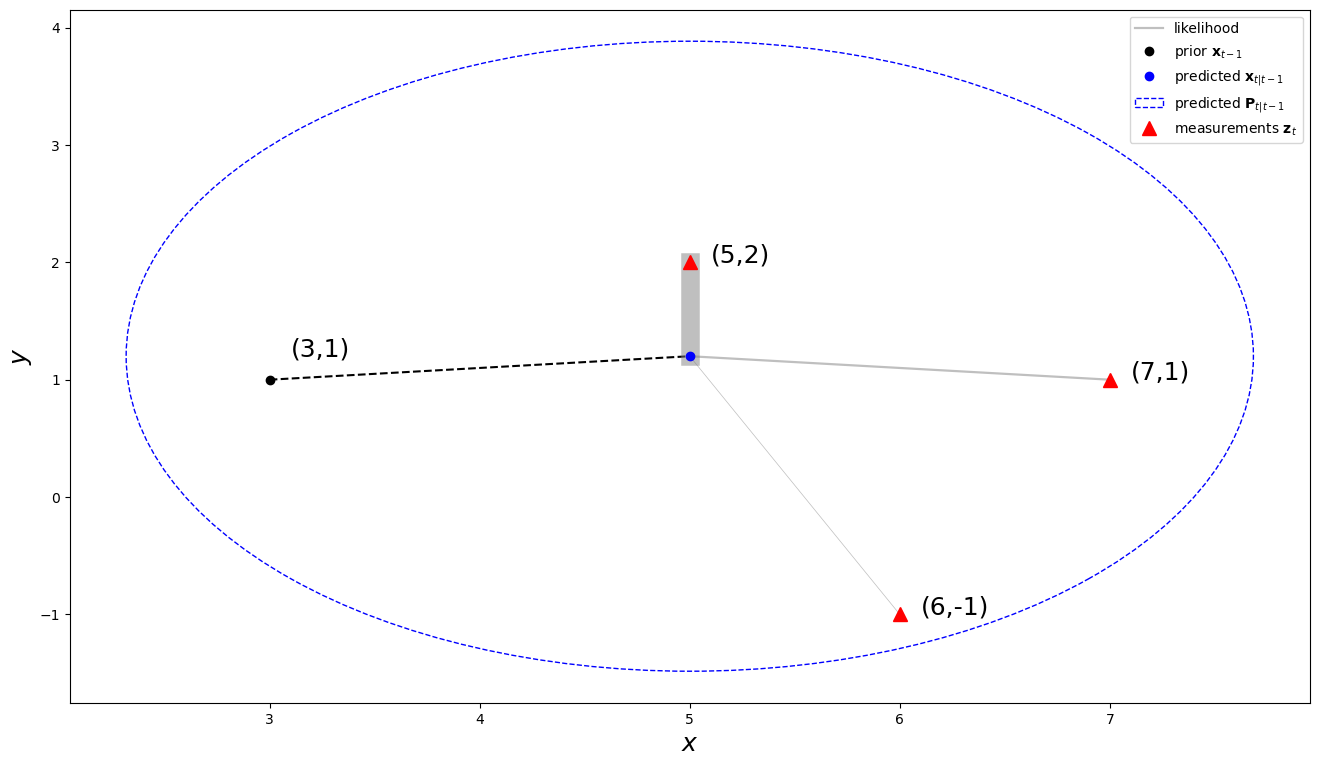

In [29]:
from models.utils import confidence_ellipse
import scipy.stats as st

fig, ax = plt.subplots(figsize=(16, 9))

# connect prior with predicted with dashed lines
for i in range(x_prior.shape[0]):
    ax.plot([x_prior[i, 0], x_predicted[i, 0]], [x_prior[i, 1], x_predicted[i, 1]], '--', color='black')

# plot all possible association with indecies
for i, x in enumerate(x_predicted):
    for j, z in enumerate(measurements):
        # make thicker for closer measurements
        distance = np.linalg.norm(x[:2] - z)
        likelihood = st.multivariate_normal.pdf(z, mean=x[:2], cov=P[i])
        ax.plot([x[0], z[0]], [x[1], z[1]], color='grey', alpha=0.5, linewidth=likelihood * 100, label='likelihood' if i == 0 and j == 1 else None)
        # association at the middle of the line
        # ax.text((x[0] + z[0]) / 2, (x[1] + z[1]) / 2, f'{i+1}{j+1}', fontsize=12)


# plot x_prior
ax.plot(x_prior[:, 0], x_prior[:, 1], 'o', color='black', label='prior $\mathbf{x}_{t-1}$')
# prior coordinates
for i, x in enumerate(x_prior):
    ax.text(x[0] + .1, x[1] + .2, f'({int(x[0])},{int(x[1])})', fontsize=18)

# plot x_predicted
ax.plot(x_predicted[:, 0], x_predicted[:, 1], 'o', color='blue', label='predicted $\mathbf{x}_{t|t-1}$')
for i, P_i in enumerate(P):
    confidence_ellipse(x_predicted[i, :2], P_i, ax, rot=70 if i == 0 else 45, edgecolor='blue', linestyle='--',
                       label='predicted $\mathbf{P}_{t|t-1}$' if i == 0 else None)

# plot measurements
ax.plot(measurements[:, 0], measurements[:, 1], '^', color='red', label='measurements $\mathbf{z}_t$', markersize=10)
# plot coordinates
for i, z in enumerate(measurements):
    ax.text(z[0] + .1, z[1], f'({z[0]},{z[1]})', fontsize=18)

plt.legend()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
# plt.show()
plt.savefig(save_path / '02_07_PDA_example_2.svg', format='svg', dpi=300)

In [30]:
# Data from simulations

x_updaed = np.array([[ 5.79237135,  0.84238239,  2.47071566, -0.01244611]])
P_updated = np.array([
    [[ 2.17007513, -0.26826121,  1.28915354, -0.1593631 ], [-0.26826121,  2.74712085, -0.1593631,   1.63195298], [ 1.28915354, -0.1593631,   1.21147735, -0.09467115], [-0.1593631,   1.63195298, -0.09467115,  1.41512058]]
])
betas = [0.37307058, 0.32417119, 0.30093419]

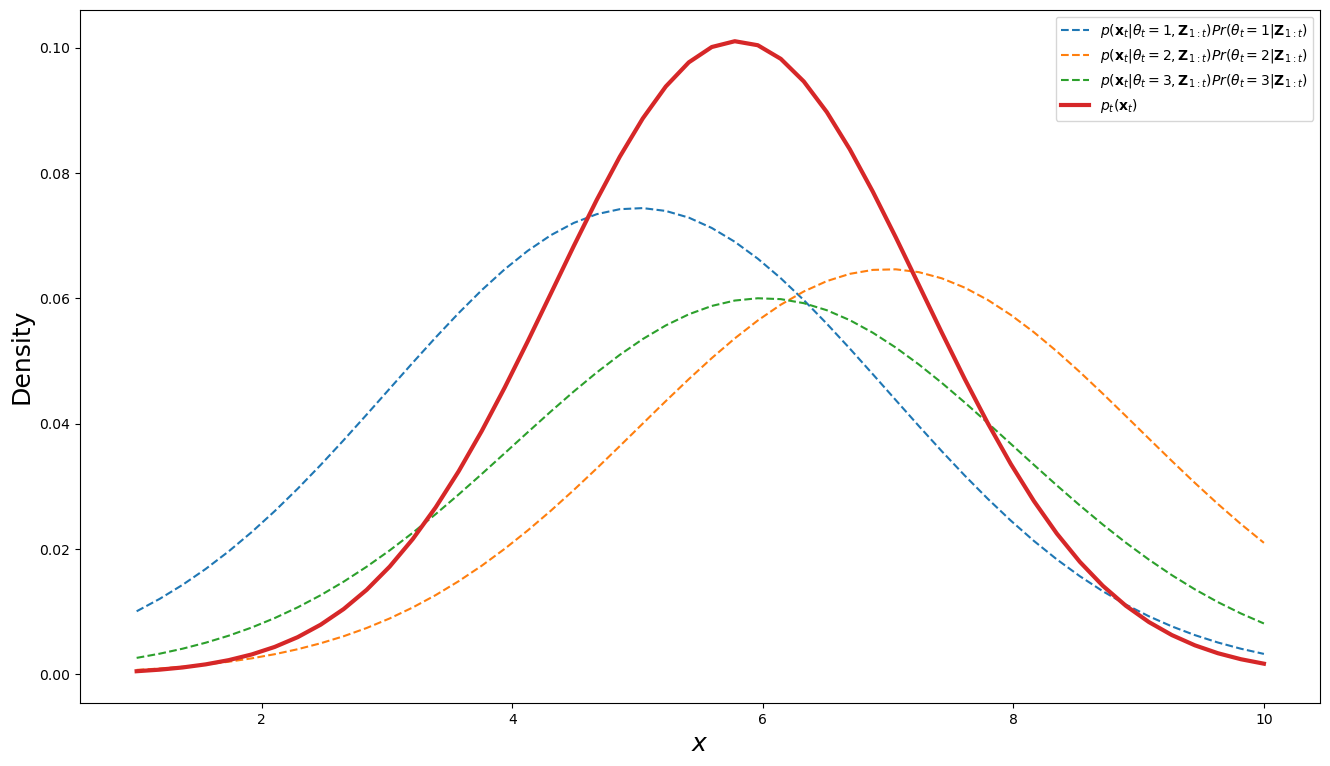

In [31]:
# gauss mixture reduction for x
densities = [
    st.norm(loc=measurements[0][0], scale=2),
    st.norm(loc=measurements[1][0], scale=2),
    st.norm(loc=measurements[2][0], scale=2)
]
mix_density = st.norm(loc=x_updaed[0][0], scale=np.sqrt(P_updated[0][0, 0]))
# plot
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(1, 10)
for i, density in enumerate(densities):
    ax.plot(x, betas[i] * density.pdf(x), '--', label=f'$p(\mathbf{{x}}_t|\\theta_t = {i+1}, \mathbf{{Z}}_{{1:t}})Pr(\\theta_t={i+1}|\mathbf{{Z}}_{{1:t}})$')
ax.plot(x, betas[0] * mix_density.pdf(x), label='$p_t(\mathbf{x}_{t})$', linewidth=3)

plt.xlabel('$x$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.legend()

plt.savefig(save_path / '02_08_PDA_example_mixture_reduction.svg', format='svg', dpi=300)

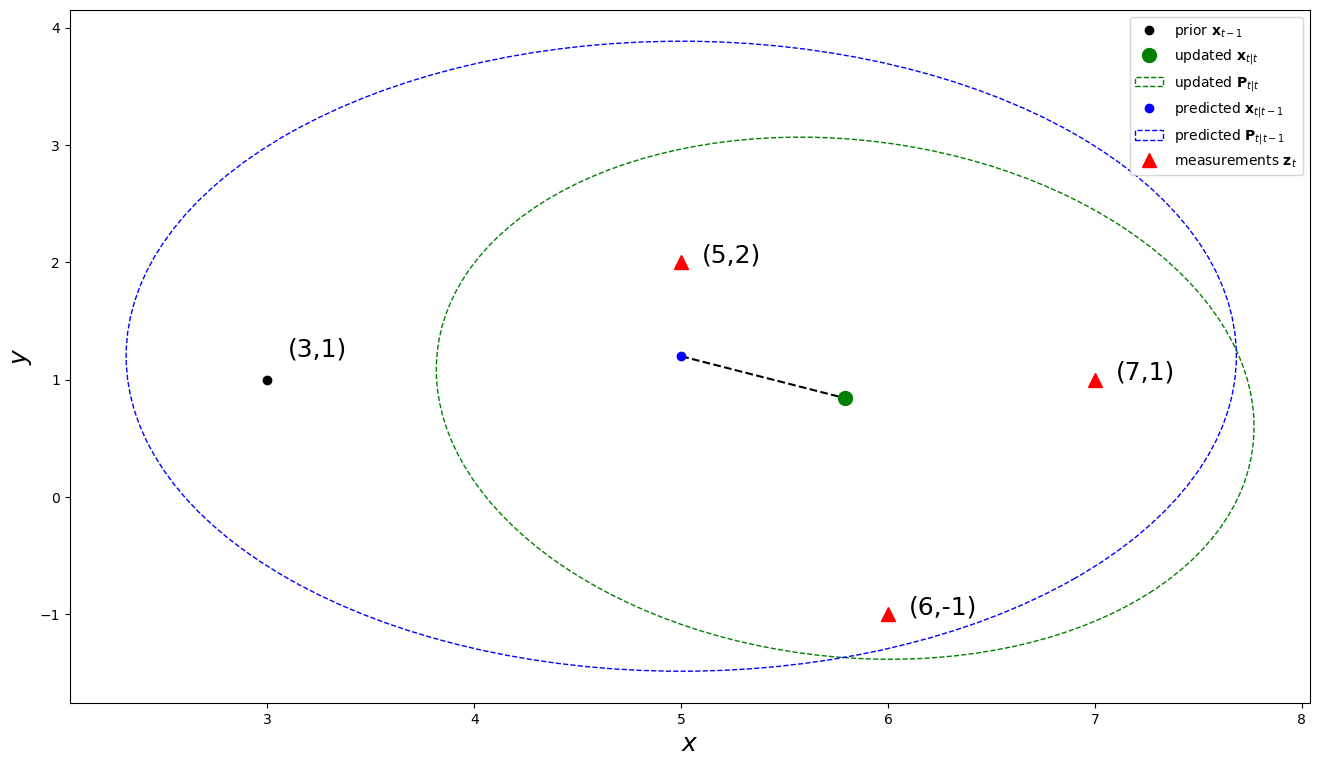

In [32]:
from models.utils import confidence_ellipse
import scipy.stats as st

fig, ax = plt.subplots(figsize=(16, 9))

# connect prior with predicted with dashed lines
for i in range(x_prior.shape[0]):
    ax.plot([ x_predicted[i, 0], x_updaed[i, 0]], [x_predicted[i, 1], x_updaed[i, 1]], '--', color='black')

# plot x_prior
ax.plot(x_prior[:, 0], x_prior[:, 1], 'o', color='black', label='prior $\mathbf{x}_{t-1}$')
# plot x_updated
ax.plot(x_updaed[:, 0], x_updaed[:, 1], 'o', color='green', markersize=10,  label='updated $\mathbf{x}_{t|t}$')
# updated covariance
confidence_ellipse(x_updaed[0, :2], .2 * P_updated[0, :2, :2], ax, rot=45, edgecolor='green', linestyle='--', label='updated $\mathbf{P}_{t|t}$')

# prior coordinates
for i, x in enumerate(x_prior):
    ax.text(x[0] + .1, x[1] + .2, f'({int(x[0])},{int(x[1])})', fontsize=18)

# plot x_predicted
ax.plot(x_predicted[:, 0], x_predicted[:, 1], 'o', color='blue', label='predicted $\mathbf{x}_{t|t-1}$')
for i, P_i in enumerate(P):
    confidence_ellipse(x_predicted[i, :2], P_i, ax, rot=70 if i == 0 else 45, edgecolor='blue', linestyle='--',
                       label='predicted $\mathbf{P}_{t|t-1}$' if i == 0 else None)

# plot measurements
ax.plot(measurements[:, 0], measurements[:, 1], '^', color='red', label='measurements $\mathbf{z}_t$', markersize=10)
# plot coordinates
for i, z in enumerate(measurements):
    ax.text(z[0] + .1, z[1], f'({z[0]},{z[1]})', fontsize=18)

plt.legend()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
plt.savefig(save_path / '02_09_PDA_example_updated.svg', format='svg', dpi=300)

## Kalman

In [33]:
from models.KF_simple import KF

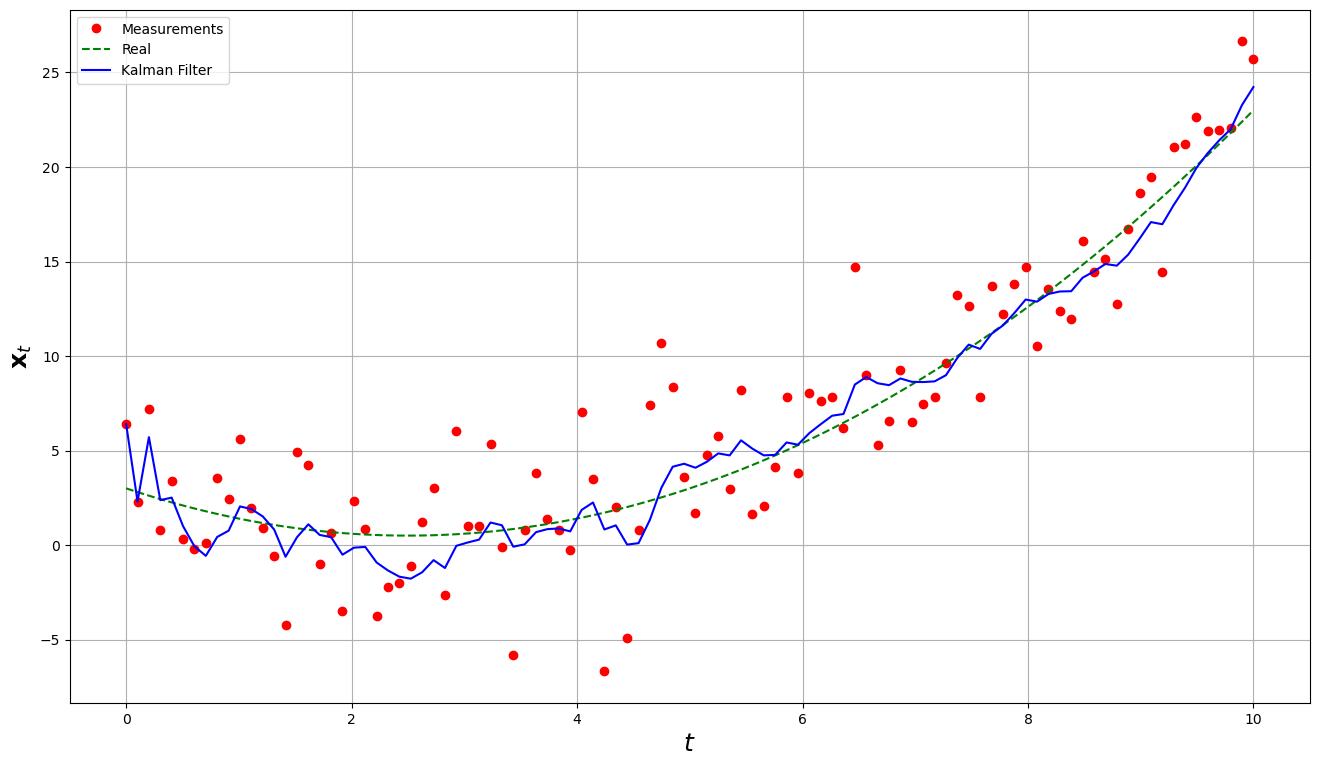

In [34]:
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
H = np.array([[1, 0]])
Q = np.array([[0.0001, 0], [0, 0.0001]])
R = np.array([[.3]])
kf = KF(A, B, H, Q, R)

X = np.linspace(0, 10, 100)
Y_real = .4 * X ** 2 - 2 * X + 3
# add noise
Y = Y_real + np.random.normal(0, 3, 100)

for y in Y:
    kf.predict()
    kf.update(y)
    kf.log()

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(X, Y, 'ro', label='Measurements')
ax.plot(X, Y_real, 'g--', label='Real')
ax.plot(X, [x[0] for x in kf.log_x], 'b', label='Kalman Filter')
plt.legend()
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$\mathbf{x}_t$', fontsize=18)
plt.grid(True)
plt.savefig('/Users/saladartem/Documents/FIT/Masters/Thesis/figures/02_05_kalman_filter.svg', bbox_inches='tight', dpi=300)

## JPDA example

In [35]:
x_prior = np.array([[3, 1, 1.2, 1.2], [1, 4, .7, 2]])
P = [np.eye(2) * 1.2, np.eye(2) * 1]
F = np.array([[1, 0, 1, 0],  # state transition matrix
              [0, 1, 0, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
x_predicted = x_prior @ F.T
measurements = np.array([
    [3, 7.2],
    [4.2, 5.1],
    [3.5, 4],
    [6.2, 0.5],
    [5.5, 2]
])

In [36]:
from models.utils import confidence_ellipse
import scipy.stats as st

fig, ax = plt.subplots(figsize=(16, 9))

# connect prior with predicted with dashed lines
for i in range(x_prior.shape[0]):
    ax.plot([x_prior[i, 0], x_predicted[i, 0]], [x_prior[i, 1], x_predicted[i, 1]], '--', color='black')

# plot all possible association with indecies
for i, x in enumerate(x_predicted):
    for j, z in enumerate(measurements):
        # make thicker for closer measurements
        distance = np.linalg.norm(x[:2] - z)
        likelihood = st.multivariate_normal.pdf(z, mean=x[:2], cov=P[i]) * 100
        ax.plot([x[0], z[0]], [x[1], z[1]], color='grey', alpha=0.5, linewidth=1)
        # association at the middle of the line
        # ax.text((x[0] + z[0]) / 2, (x[1] + z[1]) / 2, f'{i+1}{j+1}', fontsize=12)


# plot x_prior
ax.plot(x_prior[:, 0], x_prior[:, 1], 'o', color='black', label='prior $\mathbf{x}_{t-1}$')


# plot x_predicted
ax.plot(x_predicted[:, 0], x_predicted[:, 1], 'o', color='blue', label='predicted $\mathbf{x}_{t|t-1}$')
for i, P_i in enumerate(P):
    confidence_ellipse(x_predicted[i, :2], P_i, ax, rot=70 if i == 0 else 45, edgecolor='blue', linestyle='--',
                       label='predicted $\mathbf{P}_{t|t-1}$' if i ==0 else None)
    # text coordinates
    ax.text(x_predicted[i, 0] + .1, x_predicted[i, 1] + .1, f'({int(x_predicted[i, 0])},{int(x_predicted[i, 1])})', fontsize=18)
    # plot x_j
    ax.text(x_predicted[i, 0] + .1, x_predicted[i, 1] - .5, f'$\hat{{\mathbf{{x}}}}_{i+1}$', fontsize=18)


# plot measurements
ax.plot(measurements[:, 0], measurements[:, 1], '^', color='red', label='measurements $\mathbf{z}_t$', markersize=10)

# plot measurements coordinates
for i, z in enumerate(measurements):
    # ax.text(z[0] + .1, z[1], f'({z[0]},{z[1]})', fontsize=18)
    # plot z_i
    ax.text(z[0] + .1, z[1] - .5, f'$\mathbf{{z}}_{i+1}$', fontsize=18)

plt.legend()
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$y$', fontsize=18)
# plt.show()
plt.savefig(save_path / '03_01_JPDA_Example.svg', format='svg', dpi=300)

## Chi-square percentille function

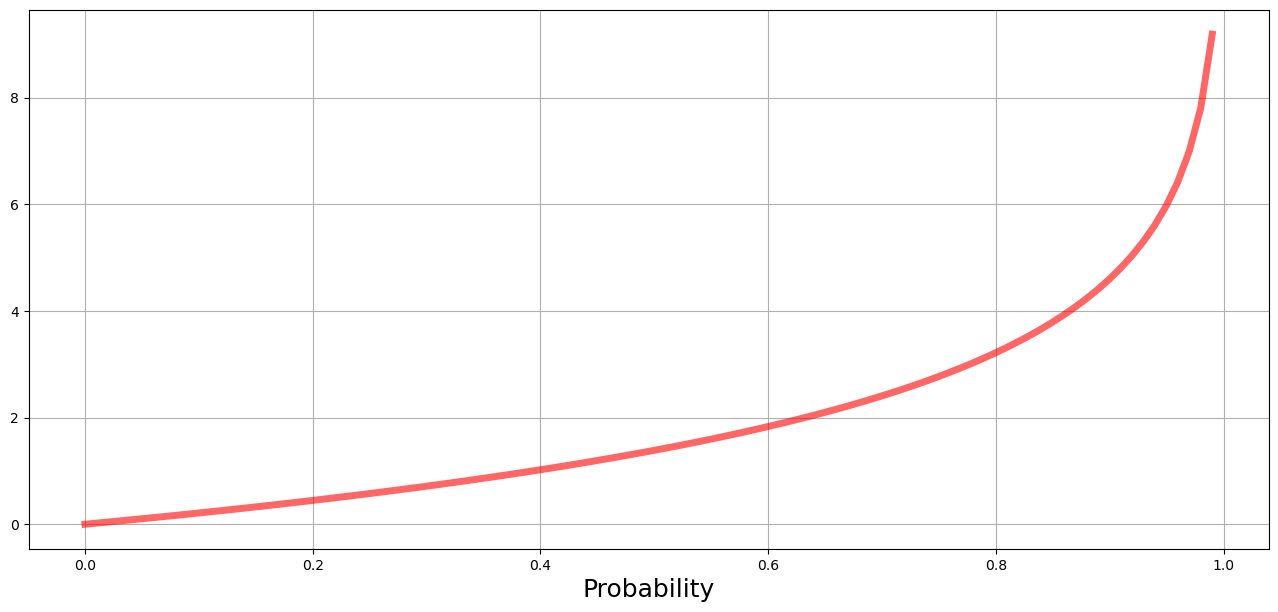

In [37]:
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)
y = chi2.ppf(x, 2)
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='chi2 pdf')
plt.xlabel('Probability', fontsize=18)
plt.grid(True)
plt.savefig(save_path /'04_01_chi2_percentile.svg', bbox_inches='tight', dpi=300)